# I - The TensorFlow 2 API - Notes
### 2022/06/16, Ahmed J Zerouali
### Updated: 2022/07/06

## 1) Introduction
This notebook gathers some fundamentals of the TF2 API, following S Ravichandiran's "Deep RL with Python" Ch. 8. The main objective is to record a high level overview of this library and get a working understanding of its functioning.

**Comment:** Ravichandiran's presentation is not how I would do it. I'll follow him first and then make the appropriate changes to these notes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
import warning


In [2]:
!matplotlib inline

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Scripts\matplotlib-script.py", line 10, in <module>
    sys.exit(plotting._matplotlib())
AttributeError: module 'pandas.plotting' has no attribute '_matplotlib'


A word of caution. Ravichandiran first explains how TF1.x worked, and later focuses on TF2. For example, the "Hello TensorFlow" example on p.320 is applicable to version 1:

            hello = tf.constant("Hello TensorFlow")
            sess = tf.Session()
            print(sess.run(hello))
            
This code returns an error in TF2, since the Session() module has been moved to *compat.v1*. See: https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session.

One way to reproduce the code above in TF2.x is as follows:

In [6]:
# We'll clarify the meaning of this call later (see graph mode and eager execution below)
tf.compat.v1.disable_eager_execution()

tf_hello = tf.constant("Hello TensorFlow 2")
test_session = tf.compat.v1.Session()
print(test_session.run(tf_hello))

b'Hello TensorFlow 2'


In [4]:
help(tf.compat.v1.Session)

Help on class Session in module tensorflow.python.client.session:

class Session(BaseSession)
 |  Session(target='', graph=None, config=None)
 |  
 |  A class for running TensorFlow operations.
 |  
 |  A `Session` object encapsulates the environment in which `Operation`
 |  objects are executed, and `Tensor` objects are evaluated. For
 |  example:
 |  
 |  ```python
 |  tf.compat.v1.disable_eager_execution() # need to disable eager in TF2.x
 |  # Build a graph.
 |  a = tf.constant(5.0)
 |  b = tf.constant(6.0)
 |  c = a * b
 |  
 |  # Launch the graph in a session.
 |  sess = tf.compat.v1.Session()
 |  
 |  # Evaluate the tensor `c`.
 |  print(sess.run(c)) # prints 30.0
 |  ```
 |  
 |  A session may own resources, such as
 |  `tf.Variable`, `tf.queue.QueueBase`,
 |  and `tf.compat.v1.ReaderBase`. It is important to release
 |  these resources when they are no longer required. To do this, either
 |  invoke the `tf.Session.close` method on the session, or use
 |  the session as a conte

**Comment:** We will work with TF1.x for a bit starting this point...

In [3]:
# Diable eager execution
tf.compat.v1.disable_eager_execution()

## 2) Graphs and sessions


### 2.a - Computational graphs

Computational graphs are the foundational structure of TF1. The image below illustrates the computational graph of the function $f(x) = \text{ReLU}(Wx+b)$:

<img src = "Figures/TF_Graphs_Ravichandiran_Fig_8.1.png" style = "height: 320px;" >

In these graphs:
* *Nodes* are mathematical operations;
* *Edges* are tensors;
* There are *direct dependencies*, when the output of a node depends on that of another node;
* *Indirect* dependencies when the output of a node doesn't depend on that of another node.

**Questions/Comments:** 

* The graphs give an abstract representation of neural networks. More generally, TensorFlow always builds a computational graph of the tensors and operations used. These are stored in "working_directory/graphs". Later, we'll see how to access these through TensorBoard.
* The dependencies are important for resource allocation. When building a computational graph, the independent dependencies are distributed accross the available resources to reduce computation time (if I understand well, the goal is to paralellize the computations).

By default, every computation in TF1 is represented by such a graph, and creating a session builds a default graph. We'll get back to this point in the next section, in the meantime, here is how one creates a graph:

In [ ]:
# Simple graph
a = tf.constant(5,name = "a")
b = tf.multiply(a, 3, name = "b")
graph_0 = tf.compat.v1.Graph()

# Set this graph as default
with graph_0.as_default():
    z = tf.add(a,b, name="Add")

The cell above creates the following graph:

<img src = "Figures/TF_Graphs_Graph-Example_1.png" style = "height: 160px;" >

To see it however, it has to be run in a session. To summarize this part:

* The **Graph()** class is the foundational computational structure of TF1. In TF2, it is instantiated via **tf.compat.v1.Graph()**.
* Most of the old modules and functions of TF1 have been moved to **tf.compat.v1**.
* The basic operations (*multiply()*, *add()*) are directly called from "tf".

### Disgression: The with statement

The *with* statement is used a lot in TensoFlow, and falls within the realm of context managers in Python. The little that we record here is taken from:

https://realpython.com/python-with-statement/#the-with-statement-approach

The *with* statement creates a runtime context to manage a set of instructions. The general syntax is as follows:

            with expression as target_var:
                do_something(target_var)
                
When running into such a block of code, Python does the following:

1) Call *expression* to obtain a context manager.

2) Store the context manager’s .__enter__() and .__exit__() methods for later use.

3) Call .__enter__() on the context manager and bind its return value to *target_var* if provided.

4) Execute the *with* code block. 

5) Call .__exit__() on the context manager when the *with* code block finishes.

A good idea is to compare this with the code:

            with open("hello.txt", mode="w") as file:
                file.write("Hello, World!")
                
Once the interpreter calls .__**exit**__(), there is also some cleanup being executed such as closing the file. More generally, the interpreter releases the acquired resources upon exiting the *with* code block.

The main advantages for using *with* are that it:

* Makes resource management safer than its equivalent try … finally statements.
* Encapsulates standard uses of *try … finally* statements in context managers.
* Allows reusing the code that automatically manages the setup and teardown phases of a given operation.
* Helps avoid resource leaks

**Comment:** I need to read more about this. I don't fully get it, other than resource management for the particular case of computation-heavy TensorFlow.

### 2.b - Sessions

We saw how to build simple computational graphs with TensorFlow. Now to execute a graph we use a TensorFlow session.

# II - MNIST classification with TensorFlow
### 22/06/23, A.J. Zerouali
### Updated: 22/06/27

The famous deep learning with CNN exercise. The purpose of this part is to build the neural net for the classification of these handwritten digits with both of the TF1 API and TF2/Keras. I'm following Ravichandiran Ch.8 here, starting p.330.

I'm making separate imports here (next cell).

In [1]:
import warnings
warnings.filterwarnings("ignore")
# This will kill the warnings with pink background

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

## 1) Loading MNIST

Now we import the MNIST dataset:

In [7]:
mnist_keras = tf.keras.datasets.mnist

In [8]:
(X_train, y_train), (X_test, y_test) = mnist_keras.load_data()

11493376/11490434 [==============================] - 18s 2us/step


In [9]:
type(X_train)

numpy.ndarray

In [10]:
X_train.shape

(60000, 28, 28)

Let's look at one image:

In [11]:
img_1 = X_train[10,:,:]

In [12]:
img_1.shape

(28, 28)

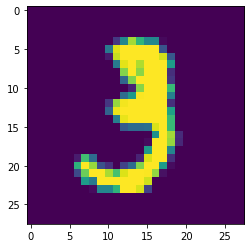

In [13]:
plt.imshow(img_1)

In [14]:
y_train[10]

3

In [19]:
img_1_flat = img_1.flatten()

In [20]:
img_1_flat.shape

(784,)

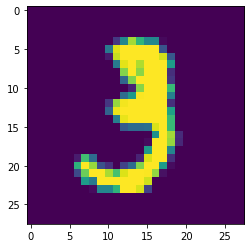

In [22]:
plt.imshow(img_1_flat.reshape(28,28))

I will save a smaller dataset of flattened images. Note that the 60k test images take-up 45MB. We'll keep a dataset of 15k training images and 3k validation images, and a 3k test set. First we reshape and save the training set and its labels:

In [48]:
Xs_train = X_train[0:18000,:,:].reshape(18000,784)
ys_train = y_train[0:18000]

In [53]:
np.save("MNIST_Small_Training_FlatImg.npy", Xs_train)
np.save("MNIST_Small_Training_Labels.npy", ys_train)

Next we do the same with the test set

In [55]:
Xs_test = X_test[0:3000,:,:].reshape(3000,784)
ys_test = y_test[0:3000]
np.save("MNIST_Small_Test_FlatImg.npy", Xs_test)
np.save("MNIST_Small_Test_Labels.npy", ys_test)

Clear 

In [56]:
del X_train, Xs_train, y_train, ys_train, X_test, Xs_test, y_test, ys_test

### MNIST reduced

(Re)Load smaller datasets

In [3]:
X_train = np.load(file = "MNIST_Small_Training_FlatImg.npy")
y_train = np.load(file = "MNIST_Small_Training_Labels.npy")

In [4]:
X_test = np.load(file = "MNIST_Small_Test_FlatImg.npy")
y_test = np.load(file = "MNIST_Small_Test_Labels.npy")

## 2) Keras ANN
### 22/07/05

For comparison purposes. More discussion and motivation in the next section.

In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from datetime import datetime

Data:

In [9]:
# Training
X_train = np.load(file = "MNIST_Small_Training_FlatImg.npy")
y_train = np.load(file = "MNIST_Small_Training_Labels.npy")
# Testing
X_test = np.load(file = "MNIST_Small_Test_FlatImg.npy")
y_test = np.load(file = "MNIST_Small_Test_Labels.npy")

In [10]:
# Flattened images:
x_train = X_train[0:15000]/255
x_val = X_train[15000:]/255
x_test = X_test/255

# One-hot labels:
y_cat_train = to_categorical(y_train[:15000], num_classes = 10)
y_cat_val = to_categorical(y_train[15000:], num_classes = 10)
y_cat_test = to_categorical(y_test, num_classes = 10)

Now we make the model. Previously, as a baseline we'll use:
* Input layer of input shape = 784;
* Layer 1 with 128 units and ReLU activation;
* Layer 2 with 64 units and ReLU activation;
* Output with 10 units and "softmax" activation;
* Adam optimizer with learning rate = 0.001;
* Cross-entropy loss.

In [11]:
# Hyperparameters
input_dim = 784
layer_1_n_units = 128
layer_2_n_units = 64
output_dim = 10
learn_rate = 0.001

# Network
keras_ann = Sequential()

keras_ann.add(keras.Input(shape = (input_dim,))) # Necessary?
keras_ann.add(Dense(units = layer_1_n_units, activation = "relu"))
keras_ann.add(Dense(units = layer_2_n_units, activation = "relu"))
keras_ann.add(Dense(units = output_dim, activation = "softmax"))

keras_ann.compile(optimizer= keras.optimizers.Adam(learning_rate=learn_rate), \
                  loss = "categorical_crossentropy", metrics = ["accuracy"])

Now we train it:

In [12]:
train_begin_time = datetime.now()
keras_ann.fit( x = x_train,
              y = y_cat_train,
              batch_size = 100,
              epochs = 10,
              verbose = 1,
              validation_data = (x_val, y_cat_val)
              )
print(f"Training of keras_ann done. Time elapsed: {datetime.now()-train_begin_time}.")

Epoch 1/10
150/150 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.8302 - val_loss: 0.3220 - val_accuracy: 0.9010
Epoch 2/10
150/150 [==============================] - 1s 4ms/step - loss: 0.2367 - accuracy: 0.9327 - val_loss: 0.2378 - val_accuracy: 0.9290
Epoch 3/10
150/150 [==============================] - 1s 4ms/step - loss: 0.1690 - accuracy: 0.9508 - val_loss: 0.1934 - val_accuracy: 0.9393
Epoch 4/10
150/150 [==============================] - 1s 5ms/step - loss: 0.1255 - accuracy: 0.9634 - val_loss: 0.1702 - val_accuracy: 0.9470
Epoch 5/10
150/150 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9713 - val_loss: 0.1612 - val_accuracy: 0.9527
Epoch 6/10
150/150 [==============================] - 1s 5ms/step - loss: 0.0752 - accuracy: 0.9788 - val_loss: 0.1608 - val_accuracy: 0.9537
Epoch 7/10
150/150 [==============================] - 1s 4ms/step - loss: 0.0632 - accuracy: 0.9830 - val_loss: 0.1495 - val_accuracy: 0.9547
Epoch 

Plot some learning curves:

In [13]:
model_hist = pd.DataFrame(keras_ann.history.history)

In [14]:
model_hist.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

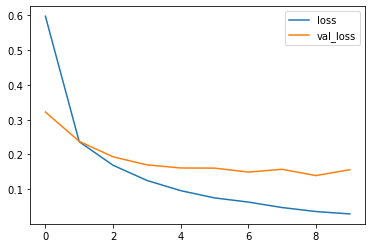

In [15]:
model_hist[["loss", "val_loss"]].plot()

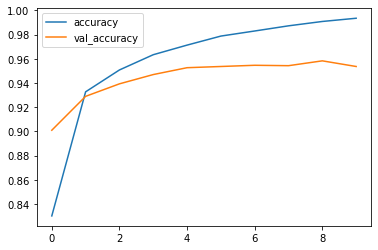

In [16]:
model_hist[["accuracy", "val_accuracy"]].plot()

## 3) Keras CNN

Before constructing our neural net from scratch using TF1 graphs, we give a quicker implementation of the desired neural net. 

**Reference:** Pierian Data's "Tensorflow 2/Keras Deep Learning Bootcamp", section on CNNs.

In [2]:
import warnings
warnings.filterwarnings("ignore")
# This will kill the warnings with pink background

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
%matplotlib inline

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
from tensorflow import keras

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten


In [6]:
# For one-hot encoding of labels
from tensorflow.keras.utils import to_categorical

Start with the following simple model:

In [7]:
# Init.
n_pxs = 28
batch_size = 100

# Instantiate model
cnn_model = Sequential()

## Add layers, input->conv->maxpool->flatten->dense->dense

# Input layer, conv
cnn_model.add(Conv2D(filters= 32, kernel_size= (4,4),\
                     activation = "relu", input_shape=(n_pxs,n_pxs,1)))
# 2nd layer, maxpool
cnn_model.add(MaxPool2D(pool_size = (2,2)))

# 3rd layer, flatten
cnn_model.add(Flatten())
# 4th layer, dense
cnn_model.add(Dense(units = 128, activation = "relu"))
# Out layer, dense
cnn_model.add(Dense(units = 10, activation = "softmax"))

# Compile model
cnn_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [8]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 591,786
Trainable params: 591,786
Non-trainable params: 0
_________________________________________________________________


Need to pre-process the data after loading it.

In [4]:
# Training
X_train = np.load(file = "MNIST_Small_Training_FlatImg.npy")
y_train = np.load(file = "MNIST_Small_Training_Labels.npy")
# Testing
X_test = np.load(file = "MNIST_Small_Test_FlatImg.npy")
y_test = np.load(file = "MNIST_Small_Test_Labels.npy")

In [5]:
x_train = X_train[0:15000]/255
x_train = x_train.reshape(15000, 28, 28, 1)
x_val = X_train[15000:]/255
x_val = x_val.reshape(3000, 28, 28, 1)

In [9]:
y_train_cat = to_categorical(y_train[0:15000])
y_val_cat = to_categorical(y_train[15000:])

Train with validation set.
**IMPORTANT:** Will not execute if eager execution isn't enabled.


In [24]:
tf.compat.v1.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [10]:
cnn_model.fit(x_train, y_train_cat, epochs = 10, validation_data=(x_val, y_val_cat))

Epoch 1/10
469/469 [==============================] - 39s 25ms/step - loss: 0.6002 - accuracy: 0.8195 - val_loss: 0.1610 - val_accuracy: 0.9510
Epoch 2/10
469/469 [==============================] - 11s 23ms/step - loss: 0.1151 - accuracy: 0.9653 - val_loss: 0.0967 - val_accuracy: 0.9713
Epoch 3/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0583 - accuracy: 0.9833 - val_loss: 0.0988 - val_accuracy: 0.9723
Epoch 4/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0347 - accuracy: 0.9910 - val_loss: 0.0824 - val_accuracy: 0.9720
Epoch 5/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.0911 - val_accuracy: 0.9747
Epoch 6/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0172 - accuracy: 0.9953 - val_loss: 0.0768 - val_accuracy: 0.9783
Epoch 7/10
469/469 [==============================] - 11s 23ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0719 - val_accuracy:

Save trained model for later use:

In [11]:
cnn_model.save("MNIST_Small_Trained_CNN.h5")

Let's check if it works:

In [6]:
img_1 = X_test[10].reshape(28,28)
img_2 = X_test[20].reshape(28,28)

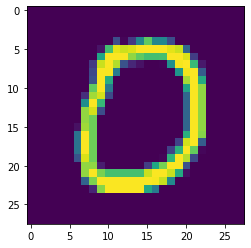

In [7]:
plt.imshow(img_1)

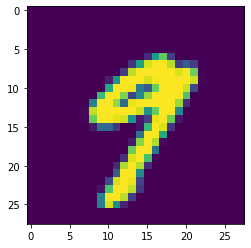

In [8]:
plt.imshow(img_2)

In [16]:
y_test_cat = to_categorical(y_test)

In [17]:
y_test_cat[10]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

Test the model:

**First image:**

In [12]:
X_test[20].shape

(784,)

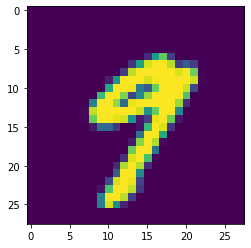

In [13]:
plt.imshow(X_test[20].reshape(28,28))

Before feeding the array to the model, recall:
* First we need to reshape the (784,) image to (28,28,1), with the 1 at the end specifying no. of color channels.
* Second, rescale the values to the interval [0,1], just like we did for the test set (i.e. divide by 255).
* Thirdly, recall that current version of TF2 modifies input_shape from (28,28,1) to (None, 28,28,1), so reshape again again accordingly (e.g. using np.array([input_image])).

In [14]:
test_img_1 = (X_test[20]/255).reshape(28,28,1)

In [19]:
test_img_1.shape

(28, 28, 1)

In [20]:
cnn_model.predict(np.array([test_img_1]))

array([[1.4919124e-07, 1.0005291e-06, 1.2346462e-08, 2.5778587e-04,
        4.1933020e-04, 9.2843635e-09, 9.0480592e-12, 5.4479414e-04,
        7.8786127e-07, 9.9877602e-01]], dtype=float32)

In [21]:
test_img_1_pred = np.argmax(cnn_model.predict(np.array([test_img_1])))

In [22]:
test_img_1_pred

9

**Second image:**

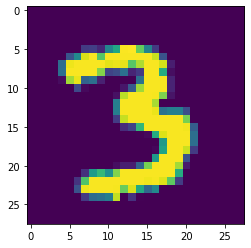

In [23]:
plt.imshow(X_test[500].reshape(28,28))

In [24]:
test_img_2 = np.array([(X_test[500]/255).reshape(28,28,1)])

In [25]:
test_img_2.shape

(1, 28, 28, 1)

In [26]:
test_img_2_pred = np.argmax(cnn_model.predict(test_img_2))
print(test_img_2_pred)

3


## 3) Classification in TF1 with ANN

In this part we will classify the reduced MNIST dataset with a fully connected ANN.

Let's start with the imports and data loading.


In [1]:
# Basic imports
import warnings
warnings.filterwarnings("ignore")
# This will kill the warnings with pink background

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# To simplify the code
import tensorflow.compat.v1 as tf1

In [2]:
!matplotlib inline

Traceback (most recent call last):
  File "C:\Users\zaj20\anaconda3\envs\DeepLearn\Scripts\matplotlib-script.py", line 10, in <module>
    sys.exit(plotting._matplotlib())
AttributeError: module 'pandas.plotting' has no attribute '_matplotlib'


In [3]:
from datetime import datetime

In [4]:
# If you want this to work
tf1.disable_eager_execution()

In [5]:
################################
##### MNIST- SMALL VERSION #####
################################

# Training
X_train = np.load(file = "MNIST_Small_Training_FlatImg.npy")
y_train = np.load(file = "MNIST_Small_Training_Labels.npy")

# Testing
X_test = np.load(file = "MNIST_Small_Test_FlatImg.npy")
y_test = np.load(file = "MNIST_Small_Test_Labels.npy")

# Pre-process
x_train = X_train[0:15000]/255
x_val = X_train[15000:]/255
x_test = X_test/255

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train[0:15000])
y_cat_val = to_categorical(y_train[15000:])
y_cat_test = to_categorical(y_test)


In [9]:
len(x_train)

15000

### a) An overview of the code

The most time-consuming part of the process is building the computational graph of our neural net. The loose organization of the code is as follows:

* **Part I: Implementation of the ANN**

1) Create namescopes for the input data and labels $(X,Y)$. Here, we declare $X$ and $Y$ as ***placeholders***, and we specify their dtype along with their dimensions/shape. **Note:** The shape is of the form [None, input_dim] (and [None, num_classes]), where "None" is for the batch size that we don't necessarily know beforehand.

2) Create namescopes for the network parameters (weights and biases) $(W^(l), b^(l))$ of the network. These are declared as ***Variables***, and must be initialized in the beginning of the training/testing sessions. Below, we will use TF's random number generators to initialize these parameters. Of course, we specify again the dtypes and the dimensions of these parameters. **Note:** For later visualization with TensorBoard, it's useful to add name arguments to the weights, and for computational efficiency, it's useful to gather the params in dictionaries.

3) Create the namescope for the model, where the layers are also declared as ***Variables***. One possible implementation is:

            with tf1.name_scope("Model"):
                layer_1 = tf1.nn.activation_1(tf1.add(tf1.matmul(X,weights["W_1"]), biases["b_1"], name = "layer_1")
                layer_2 = tf1.nn.activation_2(tf1.add(tf1.matmul(layer_1,weights["W_2"]), biases["b_2"], name = "layer_2")
                    ...
                layer_out = tf1.nn.activation_out(tf1.add(tf1.matmul(layer_(n-1),weights["W_n"]), biases["b_n"], name = "layer_n")

This is essentially what the Sequential.add() method of Keras does. In the classification example below, we'll just take a linear activation for the output layer, since the softmax will be called in the computation of the loss.

4) Create the namescope for the loss. This is again a ***Variable***, and takes the output layer as an argument. For our classification problem:

            with tf1.namescope("Loss"):
                loss = tf1.reduce_mean(tf1.nn.softmax_cross_entropy_with_logits(logits = layer_out, labels = Y))

5) As with Sequential.compile(), we are done implementing the model once we specify the loss and the optimizer. The TF1 module for optimizers is tf1.train, and when instantiating the optimizer we ***specify*** that we seek to ***minimize the loss***:

            optimizer = tf1.train.AdamOptimizer(learn_rate).minimize(loss)
            

* **Part II: The training session**

Typically, the training session is as follows:

            with tf1.Session() as training_sess:
            
                # Initialize the variables
                training_sess.run(tf1.global_variables_initializer())
                
                for epoch = 1,...,n_epochs:
                    
                    # Init. epoch loss
                    epoch_loss = 0
                
                    for batch = 1,..., n_batches:
                        
                        # Get batch and make feed dictionary
                        feed_XY = {X: batch_x, Y: batch_y}
                        
                        # Run loss and optimizer - This executes Adam/SGD on one batch
                        _, batch_loss = training_sess.run([optimizer, loss], feed_dict = feed_XY)
                        epoch_loss += batch_loss
                     
                     # Compute average loss of epoch
                     average_loss = epoch_loss/n_batches
                     
                     # Verbose
                     print(epoch, average_loss, etc)
                     
Unlike Keras, we need to add instructions if we want to keep track of the loss, the accuracy, and to save the model.



### b) Dense NN construction

The references we follow here are Ravichandiran's book, in particular:

https://github.com/sudharsan13296/Deep-Reinforcement-Learning-With-Python/blob/master/08.%20A%20primer%20on%20TensorFlow/8.05%20Handwritten%20digits%20classification%20using%20TensorFlow.ipynb.



In [6]:
#### Learning hyperparameters
learn_rate = 0.001
n_epochs = 10
batch_size = 100

#### Neuron numbers for each layer ####
num_in = 784
num_h1 = 128
num_h2 = 64
num_out = 10

#### Namescopes for placeholders of input and output layers ####
with tf1.name_scope("input"):
    X = tf1.placeholder(dtype = tf.float32, shape = [None, num_in])
with tf.compat.v1.name_scope("output"):
    Y = tf1.placeholder(dtype = tf.float32, shape = [None, num_out])
    
#### Namescopes for layer weights and biases ####
## This will be used as feed_dict later
## Using the TF1 truncated normal with
with tf1.name_scope("weights"):
    weights = {"w1":tf.Variable(tf1.truncated_normal(shape = (num_in, num_h1), stddev=0.1), name="weight_1"),
               "w2":tf.Variable(tf1.truncated_normal(shape = (num_h1, num_h2), stddev=0.1), name="weight_2"),
               "w_out":tf.Variable(tf1.truncated_normal(shape = (num_h2, num_out), stddev=0.1), name="weight_3")
              }
    
with tf.compat.v1.name_scope("biases"):
    biases = {"b1":tf.Variable(tf.constant(0.1, shape = [num_h1]), name="bias_1"),
              "b2":tf.Variable(tf.constant(0.1, shape = [num_h2]), name="bias_2"),
              "b_out":tf.Variable(tf.constant(0.1, shape = [num_out]), name="bias_3")
              } # Does this last line even make sense?
    
#### Namescope for forward propagation ####
## The next block of code replaces Sequantial.add()
## The layers are built by specifying what goes into each activation
## Makes sense, but pretty cumbersome. Also explains why weights are transposed in Keras.
with tf1.name_scope("Model"):
    with tf1.name_scope("layer1"):
        layer_1 = tf1.nn.relu(tf.add(tf.matmul(X,weights["w1"]), biases["b1"]) )
    with tf1.name_scope("layer2"):        
        layer_2 = tf1.nn.relu(tf.add(tf.matmul(layer_1,weights["w2"]), biases["b2"]) )
    with tf1.name_scope("output_layer"):    
        #layer_out = tf1.nn.softmax(tf.add(tf.matmul(layer_2,weights["w_out"]), biases["b_out"]) ) # Activation should be softmax
        layer_out = tf.add(tf.matmul(layer_2,weights["w_out"]), biases["b_out"]) 
        
#### Loss function ####
with tf1.name_scope("Loss"):
    loss = tf1.reduce_mean(tf1.nn.softmax_cross_entropy_with_logits(logits = layer_out, labels = Y)) # CLARIFY
    #loss = tf1.reduce_mean(tf1.nn.cross(logits = layer_out, labels = Y))
    # cross-entropy loss

#### Optimizer ####
optimizer = tf1.train.AdamOptimizer(learning_rate = learn_rate).minimize(loss) # CLARIFY

#### Accuracy ####
with tf1.name_scope("Accuracy"):
    predicted_label = tf1.argmax(tf1.nn.softmax(layer_out),axis = 1)
    true_label = tf1.argmax(Y,axis = 1)
    prediction_correct = tf1.equal(predicted_label, true_label)
    accuracy = tf1.reduce_mean(tf1.cast(prediction_correct, tf.float32))
    
# For TensorBoard
tf1.summary.scalar("Accuracy", accuracy)
tf1.summary.scalar("Loss", loss)
merge_summary = tf1.summary.merge_all()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
# Training session

init = tf1.global_variables_initializer()

n_batches = np.int(len(x_train)/batch_size)

# Inst. saver object
training_saver = tf1.train.Saver()
model_fname = "MNIST_ANN_Weights.ckpt"

with tf1.Session() as denseNN_sess:
    
    # Init. global variables
    denseNN_sess.run(init)
    
    # Inst. summary writer
    summary_writer = tf1.summary.FileWriter("./graphs", graph = tf1.get_default_graph())
    
    # Init. timer
    time_begin_training = datetime.now()
    
    # Loop over training epochs
    for epoch in range(n_epochs):
        
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        
        # Loop over batches
        for i_batch in range(n_batches):
            
            # Batches
            batch_x = x_train[i_batch*batch_size:(i_batch+1)*batch_size]
            batch_y = y_cat_train[i_batch*batch_size:(i_batch+1)*batch_size]
            
            # Feed dictionary
            batch_feed = {X:batch_x, Y:batch_y}
            
            # Run SGD
            ## I don't get this instruction
            #batch_loss, batch_accuracy, summary = denseNN_sess.run([loss, accuracy, merge_summary],\
            #                                                       feed_dict = batch_feed)
            _, batch_loss, batch_accuracy = denseNN_sess.run([optimizer, loss, accuracy], feed_dict = batch_feed)
            epoch_loss += batch_loss
            epoch_accuracy += batch_accuracy
            
        
        average_loss = epoch_loss/n_batches
        average_accuracy = epoch_accuracy/n_batches
        
        # Add to summary
        #summary_writer.add_summary(summary, epoch)
        #print(f"Epoch: {epoch+1}; Loss: {average_loss}; Accuracy: {batch_accuracy}.")
        print(f"Epoch: {epoch+1}; Loss: {average_loss:5.4f}; Accuracy: {average_accuracy*100:3.2f}%.")
        
    # Training tot. time
    tot_training_time = datetime.now() - time_begin_training
    print(f"Training finished. Total time: {tot_training_time}")
    
    # Save trained model
    trained_model_file = training_saver.save(sess = denseNN_sess,save_path = 'saved-models/'+model_fname)
    print(f"Trained ANN saved at {trained_model_file} as {model_fname}")
    
    # Compute accuracy on validation set
    validation_feed = {X:x_val, Y:y_cat_val}
    accuracy_val_set = denseNN_sess.run(accuracy, feed_dict = validation_feed)
    
    '''
    predictions_check = tf1.equal(tf1.argmax(layer_5_out,1),tf1.argmax(Y,1)) # CLARIFY
    accuracy_val_set = tf1.reduce_mean(tf1.cast(predictions_check, tf.float32)) # CLARIFY
    validation_feed = {X:x_val, Y:y_cat_val}
    '''
    print(f"Accuracy on validation set: {accuracy_val_set*100:3.2f}%") # CLARIFY
        


Epoch: 1; Loss: 0.7225; Accuracy: 79.59%.
Epoch: 2; Loss: 0.2870; Accuracy: 91.82%.
Epoch: 3; Loss: 0.2116; Accuracy: 93.87%.
Epoch: 4; Loss: 0.1640; Accuracy: 95.23%.
Epoch: 5; Loss: 0.1303; Accuracy: 96.27%.
Epoch: 6; Loss: 0.1044; Accuracy: 97.14%.
Epoch: 7; Loss: 0.0839; Accuracy: 97.80%.
Epoch: 8; Loss: 0.0673; Accuracy: 98.34%.
Epoch: 9; Loss: 0.0548; Accuracy: 98.71%.
Epoch: 10; Loss: 0.0446; Accuracy: 99.02%.
Training finished. Total time: 0:00:03.560165
INFO:tensorflow:saved-models\MNIST_ANN_Weights.ckpt.data-00000-of-00001
INFO:tensorflow:1300
INFO:tensorflow:saved-models\MNIST_ANN_Weights.ckpt.index
INFO:tensorflow:1300
INFO:tensorflow:saved-models\MNIST_ANN_Weights.ckpt.meta
INFO:tensorflow:1400
Trained ANN saved at saved-models/MNIST_ANN_Weights.ckpt as MNIST_ANN_Weights.ckpt
Accuracy on validation set: 94.90%


In [ ]:
# DEBUG
del denseNN_sess

y_cat_test[1236] = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


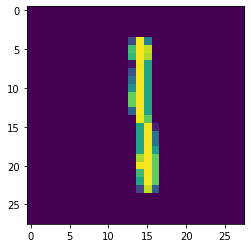

In [8]:
img_id = np.random.randint(0,3000)

print(f"y_cat_test[{img_id}] = {y_cat_test[img_id]}")

plt.imshow(x_test[img_id].reshape(28,28))
plt.show()

Now we test our model on the test set. 

**Comment:** The main issue here is how you initialize the variables in your session.

In [29]:
del test_sess_1

In [9]:
saver = tf1.train.Saver()

with tf1.Session() as test_sess_1:
    
    # Load saved model
    saver.restore(test_sess_1, "saved-models/MNIST_ANN_Weights.ckpt")
    
    # Compute and print accuracy
    test_feed = {X:x_test, Y: y_cat_test}
    accuracy_test_set = test_sess_1.run(accuracy, feed_dict = test_feed)
    print(f"Accuracy on test set: {accuracy_test_set*100:3.2f}%")


INFO:tensorflow:Restoring parameters from saved-models/MNIST_ANN_Weights.ckpt
Accuracy on test set: 94.57%


_____________________________________________

### 3.b - CNN with TF1.x

In this part, I'm re-implementing the previous Keras CNN in TF1 format. My references for this part are the following notebooks:

* https://github.com/sudharsan13296/Deep-Reinforcement-Learning-With-Python/blob/master/08.%20A%20primer%20on%20TensorFlow/8.05%20Handwritten%20digits%20classification%20using%20TensorFlow.ipynb

* https://github.com/armando-fandango/Mastering-TensorFlow/blob/master/Chapter09/ch-09a_CNN_MNIST_TF_and_Keras.ipynb

* https://github.com/PacktPublishing/TensorFlow-1x-Deep-Learning-Cookbook/blob/master/Chapter04/CNN_MINST.ipynb

As usual, we start with the relevant imports:

In [1]:
# Basic imports
import warnings
warnings.filterwarnings("ignore")
# This will kill the warnings with pink background

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# To simplify the code
import tensorflow.compat.v1 as tf1

In [2]:
!matplotlib inline

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\Scripts\matplotlib-script.py", line 10, in <module>
    sys.exit(plotting._matplotlib())
AttributeError: module 'pandas.plotting' has no attribute '_matplotlib'


In [3]:
# Fix the seed
tf1.set_random_seed(101)

In [4]:
from datetime import datetime

In [5]:
# If you want this to work
tf1.disable_eager_execution()

Next, we load the data:

In [6]:
################################
##### MNIST- SMALL VERSION #####
################################

# Training
X_train = np.load(file = "MNIST_Small_Training_FlatImg.npy")
y_train = np.load(file = "MNIST_Small_Training_Labels.npy")

# Testing
X_test = np.load(file = "MNIST_Small_Test_FlatImg.npy")
y_test = np.load(file = "MNIST_Small_Test_Labels.npy")

# Pre-process
x_train = X_train[0:15000]/255
x_val = X_train[15000:]/255

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_cat_train = to_categorical(y_train[0:15000])
y_cat_val = to_categorical(y_train[15000:])
y_cat_test = to_categorical(y_test)

The desired architecture is as follows:

            
            cnn_model = Sequential()

            ## Layers:
            cnn_model.add(Conv2D(filters= 32, kernel_size= (4,4),\
                                 activation = "relu", input_shape=(n_pxs,n_pxs,1)))
            cnn_model.add(MaxPool2D(pool_size = (2,2)))
            cnn_model.add(Flatten())
            cnn_model.add(Dense(units = 128, activation = "relu"))
            cnn_model.add(Dense(units = 10, activation = "softmax"))

            # Compile model
            cnn_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

* A 2d convolutional input layer, of input size (28,28,1) and ReLU activation.
* A maxpooling layer with ReLU activation, (2,2) pool size.
* A flattening layer (no activation).
* A dense layer with ReLU activation and 128 neurons.
* An output layer with 10 units and softmax activation.

**Comments on the CNN:**

* I don't understand why last layer doesn't have a softmax activation. 

* The softmax is part of the loss used here, which is **tf1.nn.softmax_cross_entropy_with_logits**.

* Important question: How do you make the design of a neural net in TF1.x modular? To clarify: In Keras, you create one Sequential() object to which you add the layers. For TF, it is unclear how you organize your code, given that you are building a graph. Different authors seem to have different approaches, and I haven't found one that combines  namescopes, new classes, and helper functions.

* Partial answer. Following notebook seems to follow the practice of building the NNs using helper functions: 

  https://github.com/PacktPublishing/TensorFlow-1x-Deep-Learning-Cookbook/blob/master/Chapter04/CNN_MINST.ipynb

  This code is much better organized, but doesn't answer all my questions.

* Helper functions are used to avoid the long calls to methods/classes in TF1 (I think this is what people call wrappers).

The next cell records the hyperparameters:


In [7]:
###################################
##### Network hyperparameters #####
###################################

# Input/Final Output
n_classes = 10
n_width = 28
n_height = 28
n_channels = 1
input_dim = n_height*n_width*n_channels

# Conv. layer
conv_ker_ht = 4
conv_ker_wd = 4
conv_n_filters = 32
'''
  General fomula (Calin Ex.16.9.11): 
  For input of shape (h_in, w_in), kernel of shape (k_ver, k_hor),
  strides (s_ver, s_hor), and padding p, the output shape (h_out, w_out)
  is given by:
    h_out = (h_in-k_ver+2p)/s_ver +1; w_out = (w_in-k_hor+2p)/s_hor +1.
  Note additional constraint that stride has to divide (dim_in-filter_dim+2*padding)

'''
conv_out_ht = n_height-conv_ker_ht +1
conv_out_wd = n_width-conv_ker_wd +1

# MaxPool layer
pool_ver = 2 
pool_hor = 2

# Flatten layer

# Fully conn. 1 (post flattening)
fc1_dim_in = np.int(conv_out_ht/pool_ver)*\
             np.int(conv_out_wd/pool_hor)*\
             conv_n_filters
fc1_dim_out = 128

# Training
learn_rate = 0.01
n_epochs = 20
batch_size = 100
n_batches = np.int(x_train.shape[0]/batch_size)

Here is our model now. As we'll see in TensorBoard, using namescopes groups all the subgraphs into nodes of the computational graph. I prefer this to Fandago's implementation since it gives a much cleaner graph in the end.

In [8]:
tf1.reset_default_graph()

# Placeholders for input images and labels
## x are the flattened images, y the labels
with tf1.name_scope("Input"):
    x = tf1.placeholder(dtype = tf.float32, name = "x", shape = (None, input_dim))
    x_ = tf1.reshape(x, shape = (-1,n_height,n_width,n_channels)) # Reshape input to TF1 image format
with tf1.name_scope("Output"):
    y = tf1.placeholder(dtype = tf.float32, name = "y", shape = (None, n_classes))

# Weights
with tf1.name_scope("Weights"):
    weights = {"W1":tf1.Variable(tf1.random_normal(shape=[conv_ker_ht, conv_ker_wd, n_channels, conv_n_filters],\
                                                   stddev=0.1), name = "W_1"),\
             "W4":tf1.Variable(tf1.random_normal(shape=[fc1_dim_in, fc1_dim_out]), name = "W_4") ,\
             "W5":tf1.Variable(tf1.random_normal(shape = [fc1_dim_out, n_classes]), name = "W_5") }
# Biases
with tf1.name_scope("Biases"):
    biases = {"b1":tf1.Variable(tf1.random_normal([conv_n_filters]), name = "b_1"),\
            "b4":tf1.Variable(tf1.random_normal(shape=[fc1_dim_out]), name = "b_4"),\
            "b5":tf1.Variable(tf1.random_normal(shape = [n_classes]), name = "b_5")}

# Model
with tf1.name_scope("Model"):
    
    with tf1.name_scope("Layer_1"):
        layer_1 = tf1.nn.relu(tf.add(tf1.nn.conv2d(x_, weights["W1"], strides = [1,1,1,1], padding="VALID" ),biases["b1"]))
    
    with tf1.name_scope("Layer_2"):
        layer_2 = tf1.nn.max_pool2d(layer_1, ksize = [1,pool_ver,pool_hor,1], strides = [1,pool_ver,pool_hor,1],\
                                    padding= "VALID")

    with tf1.name_scope("Layer_3"):
        layer_3 = tf1.reshape(layer_2, shape = (-1,fc1_dim_in))

    with tf1.name_scope("Layer_4"):
        layer_4 = tf1.nn.relu(tf1.add(tf.matmul(layer_3,weights["W4"]), biases["b4"]))

    with tf1.name_scope("Layer_5_out"):
        layer_5_out = tf1.add(tf1.matmul(layer_4,weights["W5"]), biases["b5"])

# Loss function
with tf1.name_scope("Loss"):
    loss = tf1.reduce_mean(tf1.nn.softmax_cross_entropy_with_logits(logits=layer_5_out, labels = y))

# Optimizer
optimizer = tf1.train.AdamOptimizer(learning_rate = learn_rate).minimize(loss) # CLARIFY

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



**Comments on the training session:** This is where we *run* the computational graph.
1) I'm following "Train and evaluate" cell at: 

https://github.com/armando-fandango/Mastering-TensorFlow/blob/master/Chapter09/ch-09a_CNN_MNIST_TF_and_Keras.ipynb

See documentation of Session.run() at https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session#run. This is the main call of the algorithm below obviously.

2) Regarding saving and loading a trained model, Fandago has the following notebook:

https://github.com/armando-fandango/Mastering-TensorFlow/blob/master/Chapter11/ch-11a_Saving_and_Restoring_TF_Models.ipynb

Highlights:

* To **save all variables in a graph**, one first makes a saver object:

      saver = tf.compat.v1.train.Saver()

  then uses a line of the form:

      saved_model_file = saver.save(tfs,'saved-models/full-graph-save-example.ckpt')

  in the session.

* To **restore all variables** in a graph, after instantiating a saver object, one uses the following in a session:

      saved_model_file = saver.restore(tfs,'saved-models/full-graph-save-example.ckpt')

  The default graph should re-initialized between sessions, and to execute the last command, we do not use the global variables initializer.

* In the link above, Fandago also shows how to save selected variables in a graph.


A training TF session for our model is as follows:


In [8]:
print(datetime.now())

2022-06-27 20:35:56.737624


In [9]:
n_batches = np.int(x_train.shape[0]/batch_size)

In [10]:
##########################
#### Training Session ####
##########################

# Reset
#tf1.reset_default_graph()

# Inst. saver object
training_saver = tf1.train.Saver()
model_fname = "CNN-v3_Weights.ckpt"

# Start new session
with tf1.Session() as sess_cnn_v3:
     
    # Initialize global variables
    tf1.global_variables_initializer().run()
    
    # Init. timer
    train_begin_time = datetime.now()
    
    # Loop over epochs
    for epoch in range(n_epochs):
        
        # Init. tot. loss
        total_loss = 0.0

        # Loop over batches
        for i_batch in range(n_batches):
            
            # Get batch
            batch_x = x_train[i_batch*batch_size:(i_batch+1)*batch_size]
            batch_y = y_cat_train[i_batch*batch_size:(i_batch+1)*batch_size]
            
            # Make feed dictionary
            batch_feed = {x:batch_x, y:batch_y}
            
            # Run CNN
            ## Note: 
            batch_loss, info = sess_cnn_v3.run([loss, optimizer], feed_dict = batch_feed)
            total_loss += batch_loss
        
        #Average loss
        avg_loss = total_loss/n_batches
        print(f"Epoch: {epoch+1}, loss = {avg_loss}")
        
    
    # End of training
    train_tot_time = datetime.now()- train_begin_time
    print(f"End of training of CNN-v3. Time elapsed: {train_tot_time}.")
    
    # Save trained model
    trained_model_file = training_saver.save(sess = sess_cnn_v3,save_path = 'saved-models/'+model_fname)
    print(f"Trained CNN saved at {trained_model_file}")
    
    # Save graph
    writer = tf1.summary.FileWriter(logdir = "./graphs", graph=sess_cnn_v3.graph)
    
    
    # Compute accuracy on validation set
    ### Following
    predictions_check = tf1.equal(tf1.argmax(layer_5_out,1),tf1.argmax(y,1)) # CLARIFY
    accuracy = tf1.reduce_mean(tf1.cast(predictions_check, tf.float32)) # CLARIFY
    validation_feed = {x:x_val, y:y_cat_val}
    print(f"Accuracy: {accuracy.eval(feed_dict= validation_feed)}") # CLARIFY

Epoch: 1, loss = 42.795692292849225
Epoch: 2, loss = 4.174912639458975
Epoch: 3, loss = 2.6393320559461912
Epoch: 4, loss = 2.247205887834231
Epoch: 5, loss = 1.6573192673176527
Epoch: 6, loss = 1.553202390919129
Epoch: 7, loss = 1.4920133795837562
Epoch: 8, loss = 1.2301429014752892
Epoch: 9, loss = 0.9753422121241844
Epoch: 10, loss = 0.750030925233638
Epoch: 11, loss = 0.6569595837518378
Epoch: 12, loss = 0.5218218749819667
Epoch: 13, loss = 0.4599154648793861
Epoch: 14, loss = 0.4828951061667115
Epoch: 15, loss = 0.3956152737833533
Epoch: 16, loss = 0.31581682828809493
Epoch: 17, loss = 0.32067511161665097
Epoch: 18, loss = 0.27669874111861514
Epoch: 19, loss = 0.27584116245503615
Epoch: 20, loss = 0.2667518464675436
End of training of CNN-v3. Time elapsed: 0:01:38.160211.
Trained CNN saved at saved-models/CNN-v3_Weights.ckpt
Accuracy: 0.937666654586792


**Comment:** In Colab, the training time for this model takes around 2min 30 for roughly the same final accuracy.

**TensorBoard:** We can look at our computational graph now:

In [11]:
# Tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

'''
  To call this use
  %tensorboard --logdir ./graphs
  IMPORTANT: Ensure that you called tf1.summary.FileWriter(logdir = "./graphs", graph=session_name.graph)
'''
%tensorboard --logdir ./graphs

Reusing TensorBoard on port 6006 (pid 3400), started 0:21:36 ago. (Use '!kill 3400' to kill it.)